In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy import ndimage
import torch

In [3]:
def centering(data,center):
    '''
    Center the image
    '''
    a=np.roll(data,(-int(np.round(center[0]+float(data.shape[0])/2)),-int(np.round(center[1]+float(data.shape[1])/2))),axis=(0,1))
    # plt.imshow(np.log(np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(data))))))
    # plt.show()
    # self.cw=ImageWindow()
    # self.cw.showPlot(a,"Centered Image")
    return a

Load data and dark image.

/var/folders/nv/1fh9k18x41n_mtsl6wznxxz40000gn/T/ipykernel_28289/1431827017.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data),cmap='hot')
/var/folders/nv/1fh9k18x41n_mtsl6wznxxz40000gn/T/ipykernel_28289/1431827017.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data),cmap='hot')


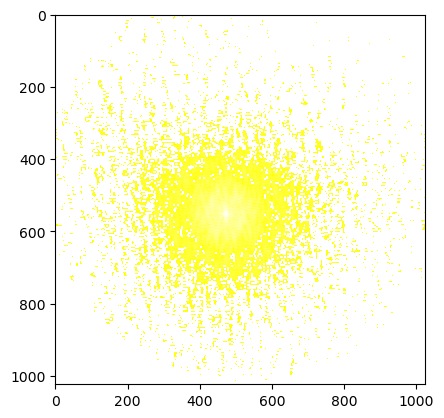

In [27]:
a=np.load('./data_squares8.npz')
dark=a['dark']
data=a['data']-dark
plt.figure()
plt.imshow(np.log10(data),cmap='hot')
plt.show()

Now we plot the autocorrelation (direct Fourier transform of the image). Here we can already see the mask.

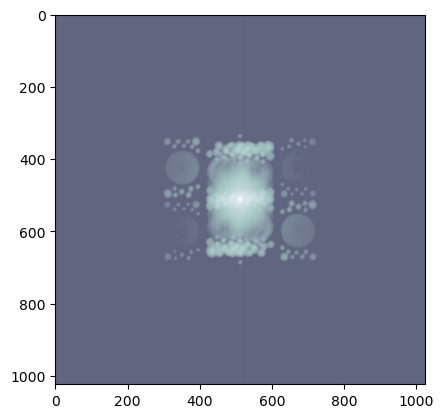

In [6]:
autocorrelation=np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(data)))
plt.imshow(np.log(np.abs(autocorrelation)),cmap='bone')
plt.show()

We try to find the center of the image.

/var/folders/nv/1fh9k18x41n_mtsl6wznxxz40000gn/T/ipykernel_28289/449547534.py:1: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  c_o_m=ndimage.measurements.center_of_mass(data) # not accurate


(548.7067006910117, 475.2905798479599)
(552, 473)


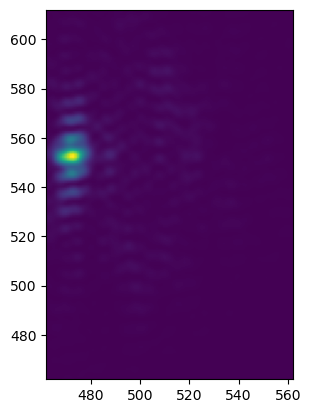

In [7]:
c_o_m=ndimage.measurements.center_of_mass(data) # not accurate
print(c_o_m)
c_w_max=np.unravel_index(np.argmax(data),data.shape)
print(c_w_max)
plt.imshow(data)
plt.xlim(int(data.shape[1]/2)-50,int(data.shape[1]/2)+50)
plt.ylim(int(data.shape[0]/2)-50,int(data.shape[0]/2)+100)
plt.show()

Now we center the image.

In [8]:
data_centered=centering(data,c_w_max)

The diffraction pattern has to be mapped onto the Ewald sphere (see e.g. Ashcroft and Mermin Ch. 6 or look up the term "Fraunhofer diffraction").

In [9]:
from scipy.interpolate import LinearNDInterpolator
def small_angle_sphere_correction(image,pixel_size,sample_distance,center_shift=[0,0]):
    '''
    Ewald sphere correction following Eqs. S10 and S9 in Raines et al., Nature 463, 
    214-217 (2010). Default uses linear interpolation with triangulation.
    '''
    x=np.arange(image.shape[1])
    y=np.arange(image.shape[0])
    x=x-(x.mean()+center_shift[1])
    y=y-(y.mean()+center_shift[0])
    xx,yy=np.meshgrid(x,y)
    # print(pixel_size,sample_distance)
    Z_normalized=sample_distance/pixel_size
    area_shrink_ratio=Z_normalized**2/(xx**2+yy**2+Z_normalized**2)
    # Generate grid on the sphere
    xcam_sphere=xx*Z_normalized/np.sqrt(Z_normalized**2-xx**2-yy**2)
    ycam_sphere=yy*Z_normalized/np.sqrt(Z_normalized**2-xx**2-yy**2)
    f=LinearNDInterpolator(list(zip(xx.ravel(),yy.ravel())),(image/area_shrink_ratio).ravel())
    return np.sqrt(f(xcam_sphere,ycam_sphere))

/var/folders/nv/1fh9k18x41n_mtsl6wznxxz40000gn/T/ipykernel_28289/3331351496.py:19: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(f(xcam_sphere,ycam_sphere))


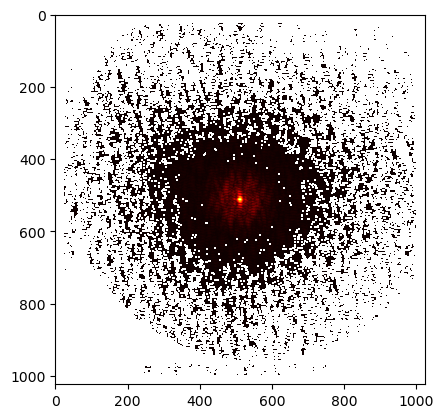

In [10]:
fourier_amplitude=small_angle_sphere_correction(data_centered,0.06,103)
plt.imshow(fourier_amplitude,cmap='hot')
plt.show()

In [11]:
np.any(np.isnan(fourier_amplitude))
fourier_amplitude[np.isnan(fourier_amplitude)]=0

Here we create the support of the image reconstruction. We create the support by overlapping two autocorrelation traces (this is only possible when specially designed masks are used).

Thoughts:
* What other method can be used to create the support?

In [12]:
%matplotlib qt
def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)
    ix=int(np.round(ix))
    iy=int(np.round(iy))
    print(ix, iy)
fig=plt.figure()
plt.imshow(np.log(np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(fourier_amplitude**2))))),cmap='bone')
cid = fig.canvas.mpl_connect('button_press_event',onclick)

514.2705627705628 341.3874458874458
514 341


In [13]:
fig.canvas.mpl_disconnect(cid)

In [14]:
%matplotlib qt
plt.figure()
sup_to_use=np.log(np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(fourier_amplitude**2)))))
plt.imshow((sup_to_use>-1.9))
plt.show()

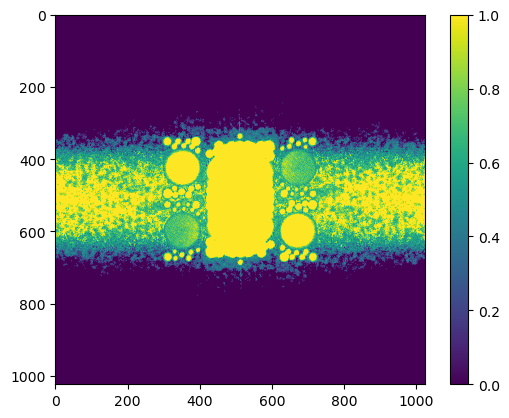

In [16]:
%matplotlib inline
support=np.zeros_like(sup_to_use,dtype=int)
support[sup_to_use>-1.9]=1
#support[support>-0.9]=1
plt.imshow(support)
plt.colorbar()
plt.show()

Here is the result of overlapping autocorrelation traces.

(1024, 1024)


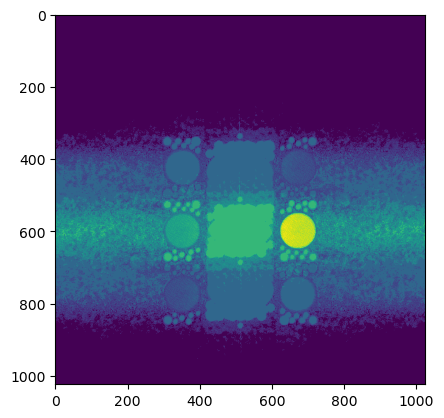

In [18]:
%matplotlib inline
from skimage.draw import disk
sup=np.roll(support,(-int(np.round(337+support.shape[0]/2)),-int(np.round(512+support.shape[1]/2))),axis=(0,1))
rr,cc=disk((599,672),50,shape=(1024,1024))
circ=np.zeros_like(support,dtype=int)
circ[rr,cc]=1
print(circ.shape)
plt.figure()
plt.imshow(sup+support+circ)
plt.show()

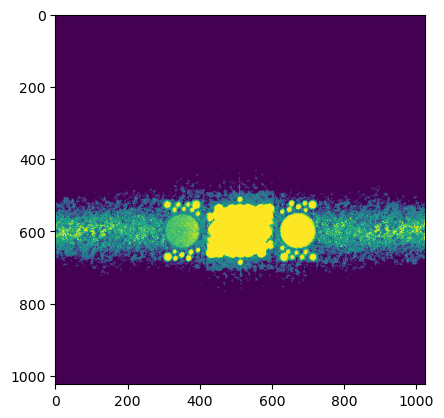

In [19]:
support=(sup+support+circ>1)
plt.imshow(support)
plt.show()

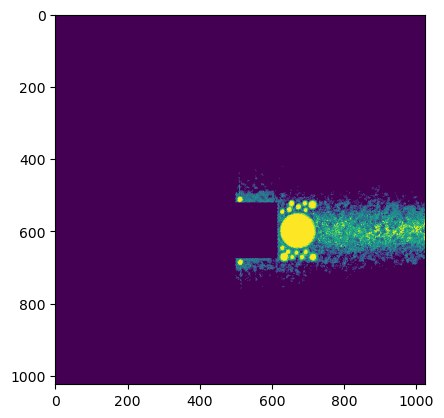

In [20]:
support[:,0:500]=0
support[521:676,500:616]=0
plt.imshow(support)
plt.show()

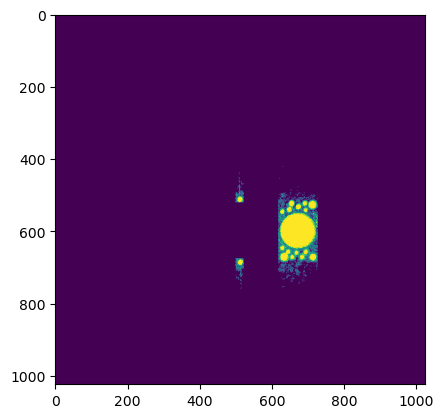

In [21]:
support[:,727:None]=0
support[:,522:618]=0
plt.imshow(support)
plt.show()

In [22]:
support=support.astype(bool)

After creating the support, we can start the reconstruction. Here we provide two algorithms: RAAR and error reduction. See 
* Fienup, Appl. Opt. 21, 2758 (1982)
* Luke, Inverse Problems 21, 37 (2005)

In [23]:
def RAAR(FTamplitude,support,maxstep=300,betastep=0,beta=0.6,FTphase=None,oldimage=None):
    # from scipy import fft
    # FTamplitude=np.sqrt(FTimage)
    FTamplitude[np.isnan(FTamplitude)]=0
    FTamplitude=torch.Tensor(FTamplitude)
    support=torch.Tensor(support)
    beta_final=0.5
    if betastep==0:
        betastep=np.tan((beta-beta_final)/maxstep)
    if type(oldimage)==np.array:
        oldimage=torch.Tensor(oldimage, dtype=torch.cfloat)
        FTphase=torch.angle(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(support*oldimage))))
    elif type(FTphase) == np.array:
        FTphase=torch.Tensor(FTphase)
    else:
        FTphase=torch.rand(*FTamplitude.shape)*np.pi*2
    # support_int=support #.astype(int)
    notsupport=(torch.logical_not(support)) #.astype(int)
    image=torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(FTamplitude*torch.exp(1j*FTphase))))
    image[notsupport]=0
    # results=[np.copy(image)]
    # print(image.dtype)
    # tgA=np.tan(beta)
    for k in range(maxstep):
        FTphase=torch.angle(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(image))))
        imagenew=torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(FTamplitude*torch.exp(1j*FTphase))))
        image=support*imagenew+notsupport*(beta*image+(1-2*beta)*imagenew)
        # results.append(image)
        beta=beta-betastep
    return image.numpy()
def ErrorReduction(FTamplitude,image,support,maxstep=10):
    FTamplitude=torch.Tensor(FTamplitude)
    image=torch.from_numpy(image)
    support=torch.from_numpy(support)
    for k in range(maxstep):
        FTphase=torch.angle(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(image))))
        imagenew=torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(FTamplitude*torch.exp(1j*FTphase))))
        image=support*imagenew
    return image.numpy()

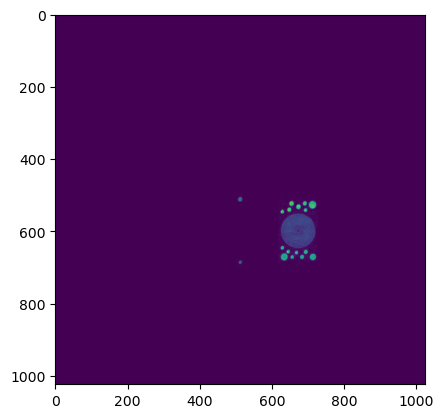

In [24]:
image=RAAR(fourier_amplitude,support,500,beta=0.95)
plt.figure()
plt.imshow(np.abs(image))
plt.show()

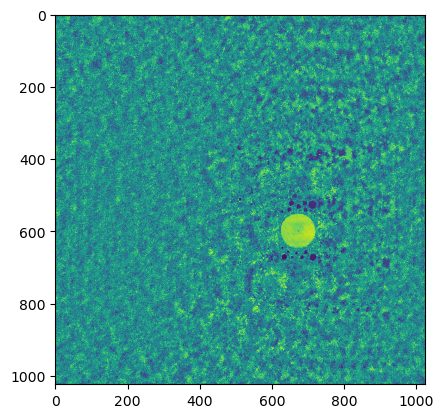

In [25]:
plt.imshow(np.angle(image))
plt.show()

Questions to think about:
* How to improve the support/reconstruction quality? (Use the image to create a new support?)
* How to improve image quality (longer exposure times)?
* What would happen to the reconstruction if there is a white pixel/column in the image? How to avoid it?